<div style="border: 5px solid; border-color:rgb(225, 104, 82); border-radius: 30px; position: relative; width: 95%; height: 300px; display: flex; justify-content: center; align-items: center; background-color: #f0f0f0;">
    <img src="https://static.vecteezy.com/system/resources/previews/036/372/442/non_2x/hospital-building-with-ambulance-emergency-car-on-cityscape-background-cartoon-illustration-vector.jpg" style="position: absolute; top: 0; left: 0; width: 100%; height: 100%; z-index: 0; opacity: 1.0; border-radius: 30px">
    <div style="position: relative; z-index: 1; text-align: center; background-color: rgba(73, 50, 41, 0.5); color: orange; display: flex; flex-direction: column; align-items: center; text-align: center; justify-content: center; width: 100%; margin: 10%; padding: 5px; border-radius: 20px">
        <h1 style="text-align: center; width: 100%; font-size: 72px; color:rgb(225, 104, 82)" ><b>Diabetes Prediction 🩺 with KNN</b></h1>
    </div>
</div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

base_path = '/kaggle/input/diabetes/diabetes.csv'
df = pd.read_csv(base_path)
TARGET = 'Outcome'

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()
sns.set_palette('coolwarm')
SNS_CMAP = 'coolwarm'
colors = sns.palettes.color_palette(SNS_CMAP)
pd.options.mode.chained_assignment = None
from typing import List, Tuple

# <div style="width: 100%"><h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgb(153, 186, 254); background-color: rgba(246, 167, 137, 0.5); padding: 30px; border: 5px solid rgb(153, 186, 254); border-style: solid; border-radius: 10px;"> EDA </h1></div>

In [2]:
df.head().style.background_gradient(cmap=SNS_CMAP)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,6,148,72,35,0,33.600000,0.627000,50,1
1,1,85,66,29,0,26.600000,0.351000,31,0
2,8,183,64,0,0,23.300000,0.672000,32,1
3,1,89,66,23,94,28.100000,0.167000,21,0
4,0,137,40,35,168,43.100000,2.288000,33,1


In [3]:
df.describe().iloc[1:].style.background_gradient(cmap=SNS_CMAP)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
agg_df = df.agg(["nunique", "unique", lambda x:x.isna().sum(), "dtypes"]).T
agg_df['unique'] = agg_df['unique'].apply(lambda x: x if len(x)<10 else x[:10])
agg_df.style.apply(lambda s: [f'background-color: rgba({colors[2][0]*255}, {colors[2][1]*255}, {colors[2][2]*255}, 0.5)' if i % 2 == 0 else f'background-color: rgba({colors[5][0]*255}, {colors[5][1]*255}, {colors[5][2]*255}, 0.5)' for i in range(len(s))])

,nunique,unique,,dtypes
Pregnancies,17,[ 6 1 8 0 5 3 10 2 4 7],0,int64
Glucose,136,[148 85 183 89 137 116 78 115 197 125],0,int64
BloodPressure,47,[72 66 64 40 74 50 0 70 96 92],0,int64
SkinThickness,51,[35 29 0 23 32 45 19 47 38 30],0,int64
Insulin,186,[ 0 94 168 88 543 846 175 230 83 96],0,int64
BMI,248,[33.6 26.6 23.3 28.1 43.1 25.6 31. 35.3 30.5 0. ],0,float64
Pedigree,517,[0.627 0.351 0.672 0.167 2.288 0.201 0.248 0.134 0.158 0.232],0,float64
Age,52,[50 31 32 21 33 30 26 29 53 54],0,int64
Outcome,2,[1 0],0,int64


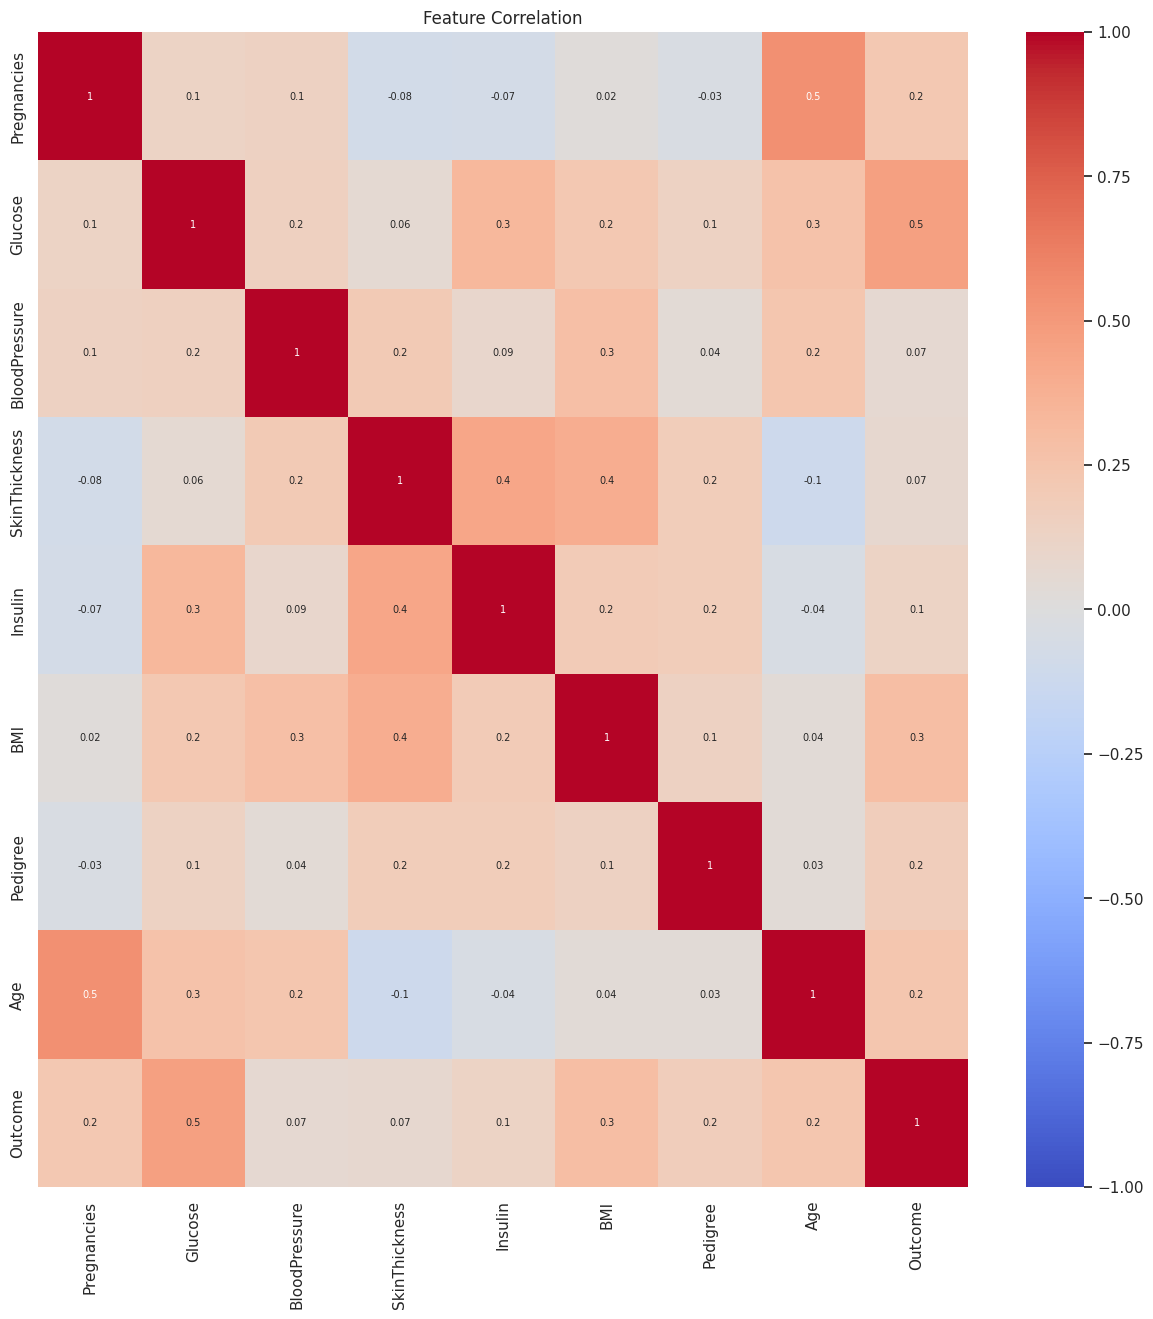

In [8]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', bool]
plt.figure(figsize=(15, 15))
sns.heatmap(df.select_dtypes(include=numerics).corr(), cmap=SNS_CMAP, annot=True, annot_kws={'fontsize':7}, fmt='.1g', vmin=-1, vmax=1, center= 0)
plt.title("Feature Correlation")
plt.show()

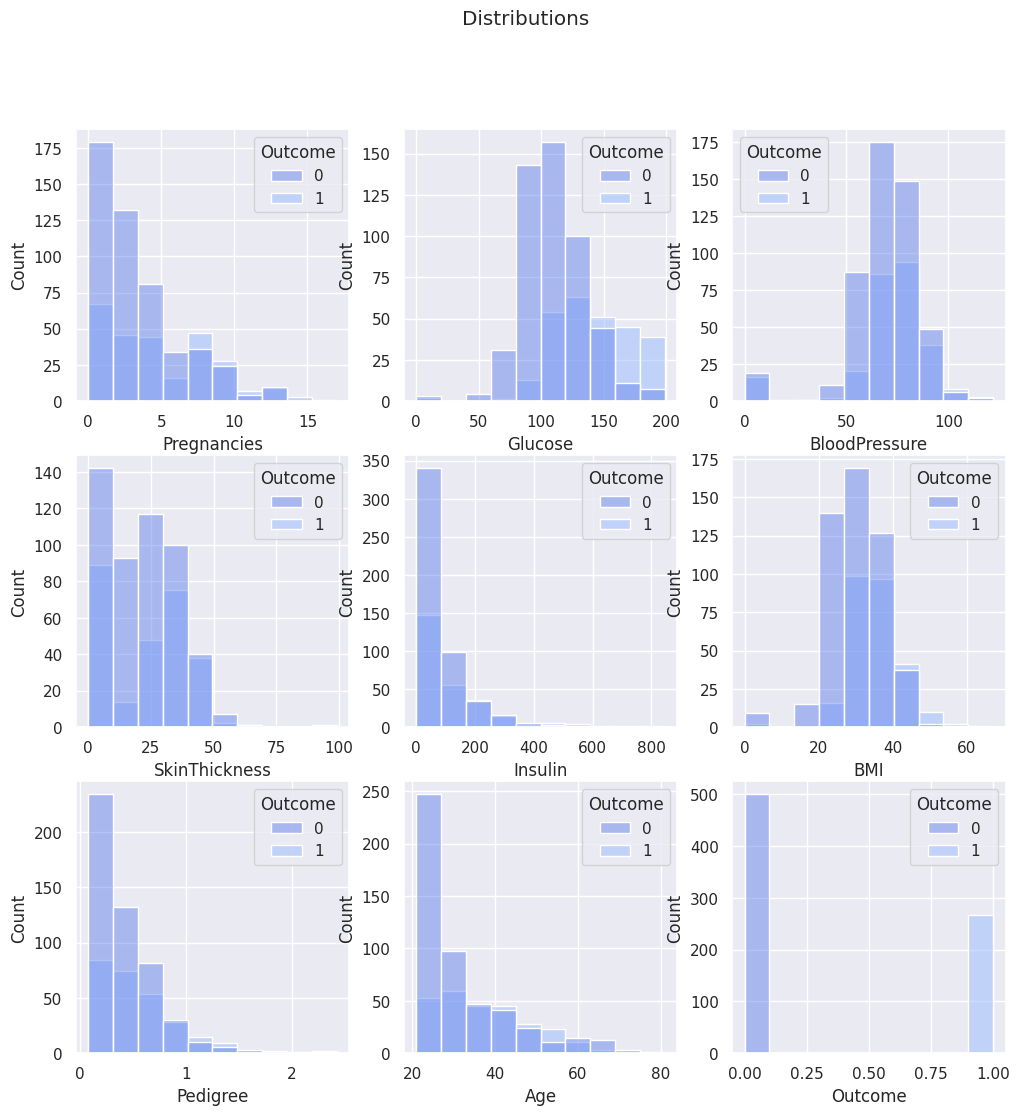

In [13]:
from typing import List

def plot_histograms_binary(df: pd.DataFrame, cols:List[str]=None, target: str = "TARGET", ncols: int = 3)->None:
    """
    Plot a series of histograms for a binary target
    
    Parameters: 
        df (Dataframe) : data to be visualized
        *params : any
    """
    if cols is None:
        cols = df.columns
    nrows = (len(cols)+ncols-1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    for i, col in enumerate(cols):
        sns.histplot(data=df, x=col, hue=TARGET, bins=10, ax=axes.flatten()[i], color=colors[4])
    fig.suptitle('Distributions')
    plt.show()
    
plot_histograms_binary(df, target = TARGET)

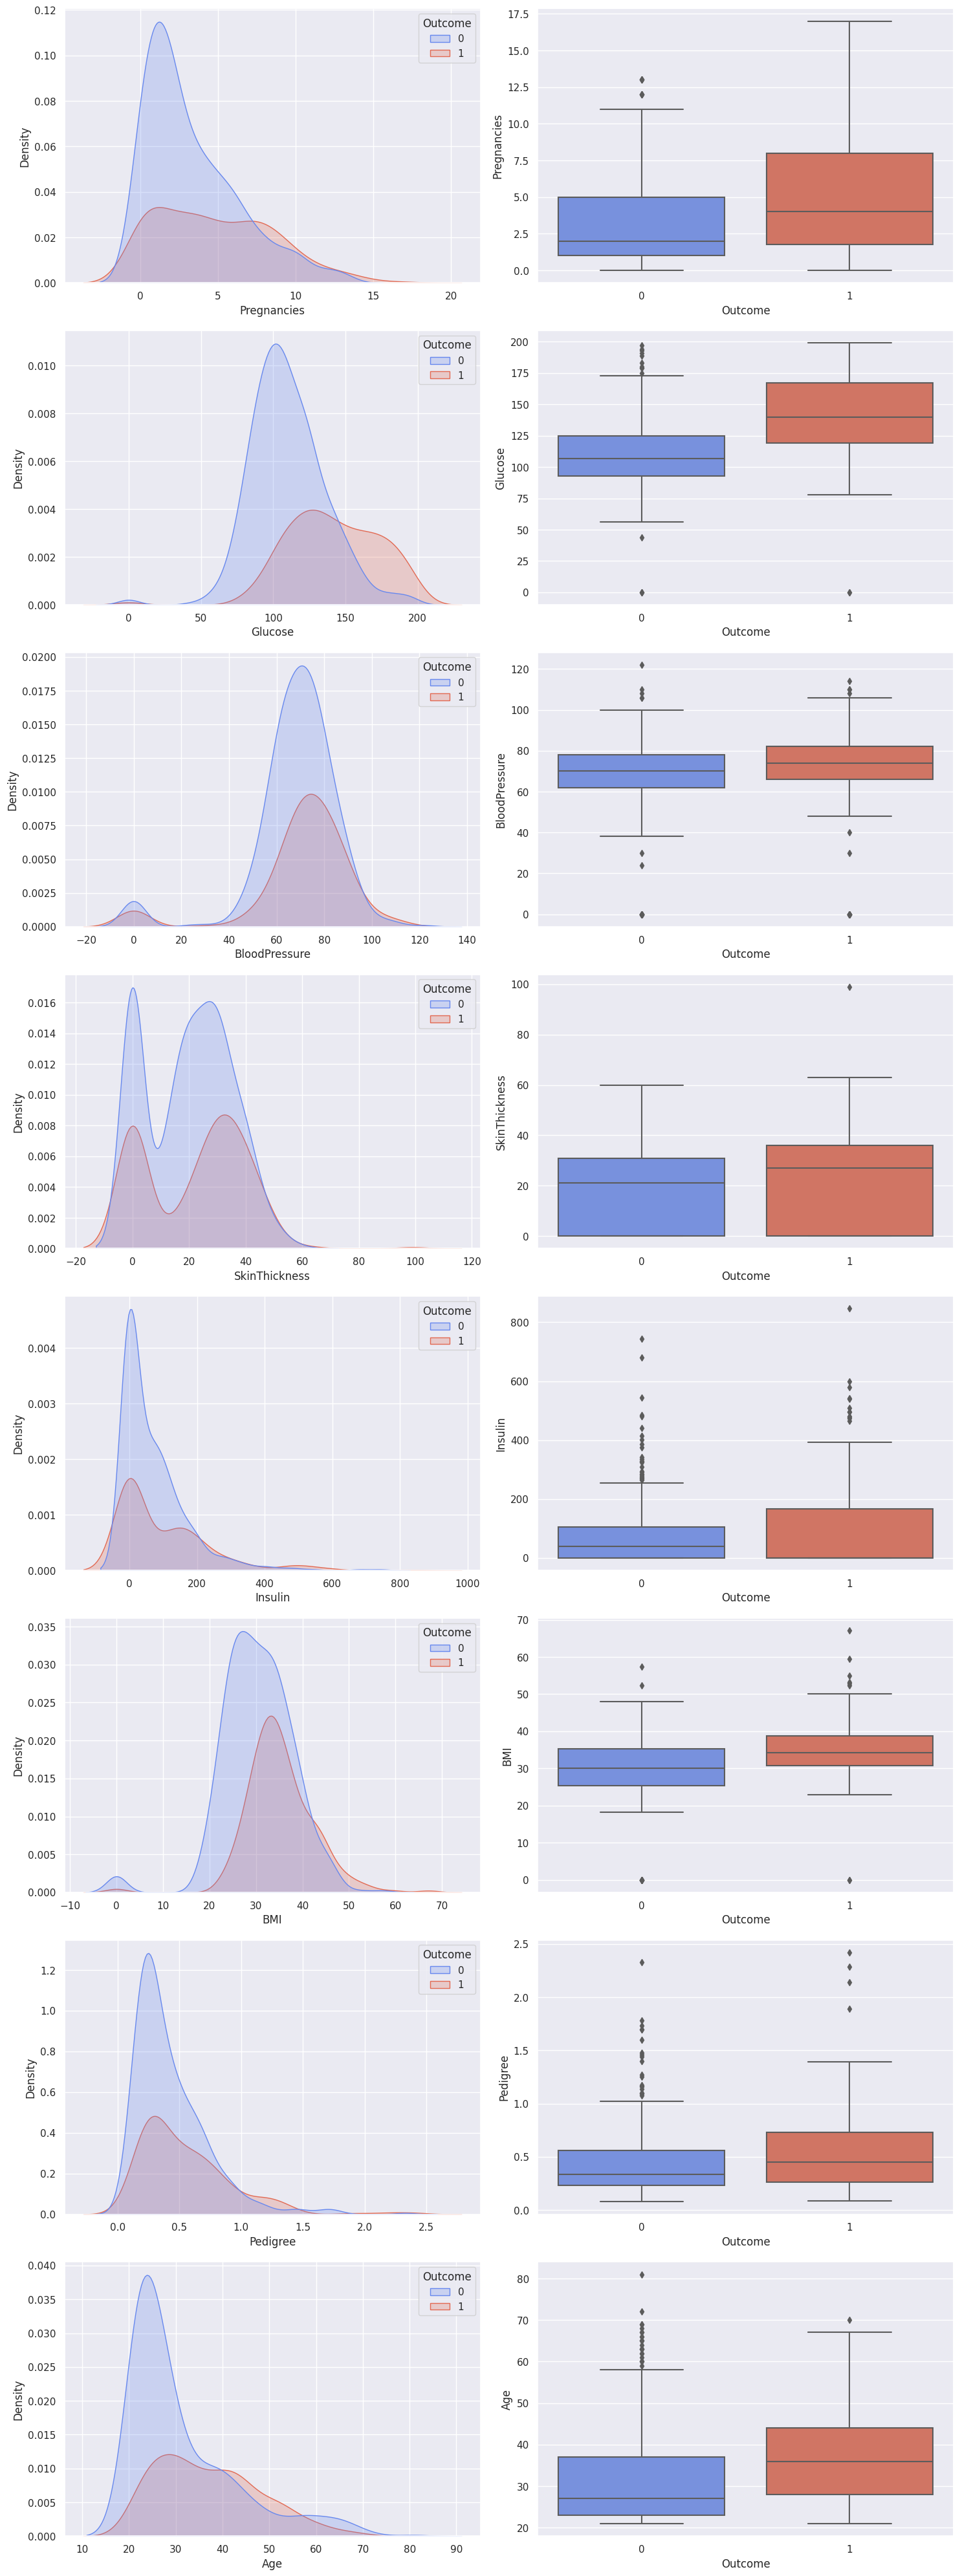

In [14]:
def plot_continous_distributions(df, target, filter_outliers = True, cols=None):
    if cols is None:
        cols = [col for col in df.columns if len(df[col].unique())>10]
    fig,axes = plt.subplots(len(cols), 2,figsize=(15, 5*len(cols)))

    for i, col in enumerate(cols):
        if filter_outliers:
            Q1, Q3 = df[col].quantile(0.2), df[col].quantile(0.8)
            IQR = Q3 - Q1
            lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
            filtered_df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        else:
            filtered_df = df
        sns.kdeplot(data = filtered_df, x=col, hue=df[target], fill=True, ax=axes[i][0], palette={0: colors[0], 1: colors[5]})
        sns.boxplot(df, y=col, x=TARGET, ax=axes[i][1], palette={0: colors[0], 1: colors[5]})
    fig.tight_layout()
    plt.show()
    
plot_continous_distributions(df, TARGET, filter_outliers = False)

# <div style="width: 100%"><h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgb(153, 186, 254); background-color: rgba(246, 167, 137, 0.5); padding: 30px; border: 5px solid rgb(153, 186, 254); border-style: solid; border-radius: 10px;"> KNN </h1></div>

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, precision_score, confusion_matrix

In [4]:
knn_classifier = Pipeline([
    ('preproc', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_classifier.fit(df.drop([TARGET], axis=1), df[TARGET].values)

Pipeline(steps=[('preproc', StandardScaler()), ('knn', KNeighborsClassifier())])

In [35]:
def classification_metrics_cv(model, X, y, cv=5):
    """
    Perform cross-validation on the given classification model and compute accuracy, AUC-ROC, and precision.

    Args:
        model: A classification model (e.g., LogisticRegression, RandomForestClassifier, etc.).
        X: Feature matrix.
        y: Target variable.
        cv: Number of cross-validation folds (default=5).

    Returns:
        tuple: Cross-validated accuracy, AUC-ROC, and precision scores.
    """
    f1_scorer = make_scorer(f1_score, average='binary')
    accuracy_scorer = make_scorer(accuracy_score)
    auc_roc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    precision_scorer = make_scorer(precision_score)

    scores = cross_validate(
        model, X, y,
        scoring={'f1': f1_scorer, 'accuracy': accuracy_scorer, 'roc_auc': auc_roc_scorer, 'precision': precision_scorer},
        cv=cv,
        return_train_score=False
    )

    f1_scores = np.mean(scores['test_f1'])
    accuracy_scores = np.mean(scores['test_accuracy'])
    auc_roc_scores = np.mean(scores['test_roc_auc'])
    precision_scores = np.mean(scores['test_precision'])
    return f1_scores, accuracy_scores, auc_roc_scores, precision_scores
    
def clrd(text: str, color: str = None):
    color_codes = {
        'ok': '\033[92m',        # Green
        'error': '\033[91m',     # Red
        'warning': '\033[93m',   # Yellow
        'success': '\033[92m',   # Green
        'status': '\033[95m',    # Magenta
        'special': '\033[94m',   # Blue
        'log': '\033[96m',       # Cyan
        'reset': '\033[0m'       # Reset to default color
    }
    color_code = color_codes.get(color, color_codes['reset'])
    return f"{color_code}{text}{color_codes['reset']}"

def print_res(model, X, Y):
    print(clrd(model, 'log'))
    model.fit(X, Y)
    f1, accuracy, auc_roc, precision = classification_metrics_cv(model, X, Y)
    print(f"Accuracy: {accuracy:.4f}   AUC-ROC: {auc_roc:.4f}   Precision: {precision:.4f}  F1: {f1:.4f}")
    print('=' * 70)
    y_pred = cross_val_predict(model, X, Y, cv=5)
    conf_matrix = confusion_matrix(Y, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

Pipeline(steps=[('preproc', StandardScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.7357   AUC-ROC: 0.7825   Precision: 0.6429  F1: 0.5913


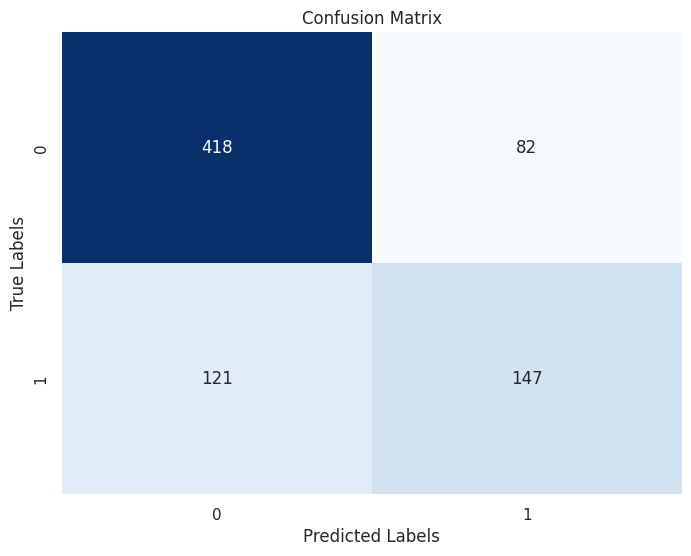

In [36]:
print_res(knn_classifier, df.drop([TARGET], axis=1), df[TARGET].values)